In [161]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [162]:
class TruncatedNormal(torch.distributions.Normal):
    def __init__(self, loc: float, scale: float, lo: float, hi: float):
        super().__init__(loc, scale)
        self.lo = lo
        self.hi = hi
        
    def sample(self, sample_shape=torch.Size()):
        sampled = super().sample(sample_shape)
        return sampled.clamp(self.lo, self.hi)
        

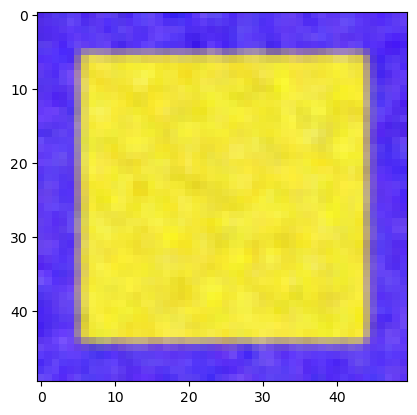

In [163]:
hue_range = [22, 37]
saturation_range = [0, 255]
value_range = [180, 255]
hue_mean = 30
saturation_mean = 200
value_mean = 255
hue_dist = TruncatedNormal(TruncatedNormal(hue_mean, 7, *hue_range).sample(), 3, *hue_range)
hue_dist2 = TruncatedNormal(TruncatedNormal(120, 9, 105, 130).sample(), 5, 105, 130)
saturation_dist = TruncatedNormal(saturation_mean, 50, *saturation_range)
value_dist = TruncatedNormal((value_mean - value_range[0]) / (value_range[1] - value_range[0]), 0.5, 0, 1)

channel_shape = 100, 100
border_width = np.random.randint(8, 12)
hue = hue_dist.sample(channel_shape)
hue2 = hue_dist2.sample(channel_shape)
hue, hue2 = cv2.blur(np.array(hue), (3, 3)), cv2.blur(np.array(hue2), (3, 3))
hue2[border_width:-border_width, border_width:-border_width] = hue[border_width:-border_width, border_width:-border_width]
saturation = saturation_dist.sample(channel_shape)
value_interval = saturation / (saturation_range[1] - saturation_range[0]) * (value_range[1] - value_range[0])
value = value_range[1] - (1 - value_dist.sample(channel_shape)) * value_interval

background = np.stack([hue2, saturation, value], axis=2).astype(np.uint8)

lemon_label_image = cv2.cvtColor(background, cv2.COLOR_HSV2RGB)
lemon_label_image = cv2.blur(lemon_label_image, (4, 4))
plt.imshow(cv2.resize(lemon_label_image, (50, 50), interpolation=cv2.INTER_AREA))

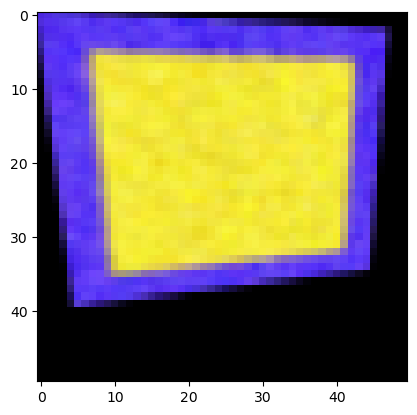

In [170]:
pts1 = np.float32([[0, 0], [0, channel_shape[1]], channel_shape, [channel_shape[0], 0]])
pts2 = np.float32([[0, 0], [10, 80], [90, 70], [95, 5]]) * 3
P = cv2.getPerspectiveTransform(pts1, pts2)
dst_perspective = cv2.warpPerspective(lemon_label_image, P, (300, 300))
plt.imshow(cv2.resize(dst_perspective, (50, 50), interpolation=cv2.INTER_AREA))